In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as fn
from torch.autograd import Variable
import numpy as np

In [2]:
from tqdm import tqdm_notebook

In [424]:
import gc

In [134]:
# Multi-Component word embeddings

class MultiComp(nn.Module):
    def __init__(self, word_embeddings_to_comp, n_comp=3):
        """
        word_embeddings_to_comp: word embeddings of the target word;
                                 shape = (n_words,100);
        
        """
        super(MultiComp, self).__init__()
        self.n_comp = n_comp
        
        n_words, embedding_size = word_embeddings_to_comp.shape
        # expand to duplicate embeddings n_comp times
        expanded_word_embeddings = np.expand_dims(word_embeddings_to_comp, 1)
        comp_embeddings = np.tile(expanded_word_embeddings, [1, n_comp, 1])
        
        # add some noise to components (1/3 of its standard deviations)
        stds = word_embeddings_to_comp.std(axis=1, keepdims=True).reshape([n_words, 1, 1])
        comp_embeddings += np.random.randn(n_words, n_comp, embedding_size)#  * stds  / 10
        comp_embeddings = np.random.randn(n_words, n_comp, embedding_size)#  * stds  / 10
        comp_embeddings = comp_embeddings.astype(np.float32)
        
        self.n_centroids = np.random.randn(n_words, n_comp, embedding_size)#  * stds  / 10
        self.n_centroids = self.n_centroids.astype(np.float32)
        
        # create variable to use autograd
        self.words_comps = nn.Parameter(torch.from_numpy(comp_embeddings))
        
#         # weight matrices for attention (times 2 because concat context and comp)
#         weights = np.random.randn(n_words, embedding_size * 2, 1)
#         # xavier
#         weights = weights * np.sqrt(2 / (embedding_size + n_comp))
#         weights = weights.astype(np.float32)
#         self.att_w = nn.Parameter(torch.from_numpy(weights))
#         self.att_b = nn.Parameter(torch.zeros(n_words, n_comp, 1))
                
    def forward(self, context_embeddigs, word_n):
        """
        context_embeddings: shape = (n_context_words, 100);
        word_n: number of main_word for what the forward is running;
        
        """
        
        # pick word_embeddings and linear layer weights
#         w_comps = self.words_comps[word_n]
#         att_w = self.att_w[word_n]
#         att_b = self.att_b[word_n]
        # sum the context across words dim 
        cont_sum = np.mean(context_embeddigs, axis=0)
        cont_sum = cont_sum.astype(np.float32)
#         print(cont_sum.shape)
#         print(self.n_centroids[word_n].shape)
#         cont_sum_repeated = cont_sum.repeat(self.n_comp, 1)
        scores_tmp = np.matmul(self.n_centroids[word_n], cont_sum)
        scores = Variable(torch.from_numpy(scores_tmp))
        scores = fn.softmax(scores, 0)
        values, indices = scores.max(0)
        
        for n in range(self.n_comp):
            self.n_centroids[word_n][n]+=cont_sum*scores[n].data
            self.n_centroids[word_n][n]/=np.sqrt(self.n_centroids[word_n][n]**2)
        
#         self.n_centroids[word_n][indices.data]+=cont_sum
#         self.n_centroids[word_n][indices.data]/=np.sqrt(self.n_centroids[word_n][indices.data]**2)
            
#         print(scores)
#         print(values, indices)

#         att_input = torch.cat([cont_sum_repeated, w_comps], dim=1)
#         att = torch.matmul(att_input, att_w) + att_b
#         att = fn.softmax(att, 0)
#         comps_sum = torch.sum(w_comps * scores.expand_as(w_comps), 0)
        comps_sum = torch.matmul(scores, self.words_comps[word_n])
        cont_sum = Variable(torch.from_numpy(cont_sum))
        dot_prod = torch.matmul(comps_sum, cont_sum.squeeze())/(torch.norm(comps_sum, p=1) * torch.norm(cont_sum, p=1))
        dot_prod -= torch.norm(cont_sum,p=2)
#         print(dot_prod)
        #         dot_prod = fn.cosine_embedding_loss(w_comps[indices.data].double(), cont_sum.squeeze(), 1, 0, True)
        return dot_prod, scores

In [504]:
net.n_centroids[0][0].shape

(100,)

# Test simple

In [135]:
w_emb = np.random.randn(3, 100)
net = MultiComp(w_emb)
opt = torch.optim.Adam(net.parameters(), lr=1e-3)


n_samples = 10000
n_context = 20 # number of words in the context
emb_dim = 100
for sample in np.random.randn(n_samples, n_context, emb_dim):
    # Prepare sample with Variable wrap
#     sample = Variable(torch.from_numpy(sample.astype(np.float32)))
    net.zero_grad()
    dot_prod, att = net.forward(sample, 0)
    loss = dot_prod
    loss.backward()
    opt.step()
#     print(loss)
#     print("attn: ", att)

In [136]:
net.words_comps[0][0].shape

torch.Size([100])

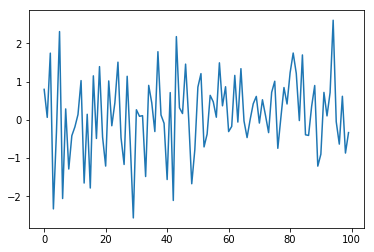

In [137]:
plt.plot(net.words_comps[0][2].data.numpy())
plt.show()

# Create dataset

In [7]:
ls -lh ../data/my_data/

total 13G
-rw-r--r-- 1 fogside fogside  8,1G янв 21 18:08 big_one_file.txt
-rw-r--r-- 1 fogside fogside   40M янв 21 18:22 dict.txt
drwxr-xr-x 3 fogside fogside  4,0K янв 21 18:05 libru/
-rw-r--r-- 1 fogside fogside  3,0M янв 17 17:42 main_contexts_and_test.txt
-rw-r--r-- 1 fogside fogside  623M янв 17 17:43 main_wiki_and_contexts.txt
-rw-r--r-- 1 fogside fogside  620M янв 14 19:34 main_words_wiki_normalized_no_punct.txt
-rw-r--r-- 1 fogside fogside  732M янв 14 18:56 main_words_wiki.txt
-rw-r--r-- 1 fogside fogside 1019M окт 20 00:10 ruwiki_00.txt
-rw-r--r-- 1 fogside fogside  1,1G янв 13 15:06 ruwiki_tokenized.txt
drwxrwxr-x 4 fogside fogside  4,0K янв 19 18:03 НКРЯ/


In [8]:
ls -lh ../models/

total 3,0G
-rw-r--r-- 1 fogside fogside 1,3G дек  8 17:42 fast_text_model.bin
-rw-r--r-- 1 fogside fogside 587M дек  8 17:42 fast_text_model.vec
-rw-r--r-- 1 fogside fogside 923M янв 22 04:51 model_big_one.bin
-rw-r--r-- 1 fogside fogside 171M янв 22 04:51 model_big_one.vec


In [5]:
from pymystem3 import Mystem
stemmer = Mystem()

In [6]:
def get_all_indexes(lst, word):
    res = []
    i = 0
    while(True):
        try:
            i = lst.index(word, i)
            res.append(i)
            i+=1
        except:
            break
    return res

In [7]:
def make_dataset(word, window):
    N = 1669868
    w = stemmer.lemmatize(word)[0]
    counter = 0

    with open("../data/my_data/big_one_file.txt", 'r') as bigf,\
    open("../data/my_data/{}_out.txt".format(word), 'a') as fout:
        for i in tqdm_notebook(range(N)):
            line = bigf.readline().split()
            if w in line:
                idxs = get_all_indexes(line, w)
                for i in idxs:
                    counter+=1
                    # each line is a group of neighbour words with length = 3*window
                    start = max(0, i-1-window) # if 0 is max then all before main word will be selected
                    fout.write(" ".join(line[start:i-1])+" "+" ".join(line[i:i+window])+'\n')
    return counter

In [60]:
make_dataset(word='замок', window=10)

100%|██████████| 1669868/1669868 [01:11<00:00, 23263.62it/s] 


111462

In [9]:
from gensim.models import KeyedVectors
wv = KeyedVectors.load_word2vec_format("../models/model_big_one.vec", binary=False)

In [10]:
with open("../data/my_data/{}_out.txt".format('замок'), 'r') as f:
    lines = f.readlines()

In [7]:
def generate_batch(lines, context_max_len):
    for line in lines:
        line = line.split()
        embedd = []
        for i, w in enumerate(line[:context_max_len]):
            try:
                embedd.append(wv[w])
            except KeyError:
                continue
        yield np.array(embedd)

In [50]:
kek = generate_batch(lines=lines, context_max_len=1)

In [51]:
lol = next(kek)

In [52]:
type(lol)

numpy.ndarray

In [53]:
# lol = np.expand_dims(lol, 0)
lol.shape

(1, 100)

In [54]:
cont_sum = np.mean(lol, axis=0)

In [55]:
cont_sum.shape

(100,)

In [138]:
w_emb = wv['замок'].reshape((1,100))
net = MultiComp(w_emb, 3)
opt = torch.optim.Adam(net.parameters(), lr=1e-4)


n_samples = len(lines)
n_context = 10 # number of words in the context
emb_dim = 100
atts = list()
epoch_num = 1
for epoch in range(epoch_num):
    batch_gen = generate_batch(lines, context_max_len=n_context)
    pbar = tqdm_notebook(batch_gen, total = n_samples)
    print("epoch_num: ", epoch)
    for n, sample in enumerate(pbar):
        # Prepare sample with Variable wrap
    #     sample = Variable(torch.from_numpy(sample.astype(np.float32)))
        net.zero_grad()
        dot_prod, att = net.forward(sample, 0)
        atts.append(att.data.numpy())
        loss = -dot_prod 
        loss.backward()
        opt.step()
        if n % 100 == 99:
            pbar.set_description("loss {:.3f}".format(float(loss.data.numpy())))

HBox(children=(IntProgress(value=0, max=111462), HTML(value='')))

epoch_num:  0



In [237]:
atts = np.array(atts)

In [238]:
atts[-20:]

array([[0.16587138, 0.13672392, 0.6974047 ],
       [0.30780715, 0.6474888 , 0.04470406],
       [0.2365743 , 0.67896855, 0.08445714],
       [0.22418965, 0.34547266, 0.43033764],
       [0.13999598, 0.8056397 , 0.05436434],
       [0.02267888, 0.92723006, 0.05009108],
       [0.02082517, 0.9725045 , 0.00667032],
       [0.43861222, 0.49424314, 0.06714462],
       [0.33819836, 0.43503675, 0.2267649 ],
       [0.06546332, 0.9089217 , 0.02561494],
       [0.25726086, 0.70269173, 0.04004737],
       [0.06654447, 0.93154997, 0.00190554],
       [0.612973  , 0.21143901, 0.17558797],
       [0.3801594 , 0.55371594, 0.06612469],
       [0.00098036, 0.06658698, 0.93243265],
       [0.08590988, 0.7397361 , 0.17435405],
       [0.10580128, 0.15874432, 0.73545444],
       [0.00522046, 0.43229625, 0.5624833 ],
       [0.0517174 , 0.6292154 , 0.3190672 ],
       [0.03816398, 0.32324395, 0.63859206]], dtype=float32)

In [235]:
wv.similar_by_vector(net.n_centroids[0][2].data.numpy(), 30)

AttributeError: 'MultiComp_triplet' object has no attribute 'n_centroids'

In [239]:
net.words_comps[0].data.numpy()[2]

array([-1.2541687 ,  1.8582964 , -0.31258792,  0.2665987 , -0.43048805,
       -0.21790884, -0.04610474, -0.81280226, -1.9765189 , -1.0311747 ,
       -1.2336148 ,  1.083003  ,  1.2231673 , -1.1865796 ,  1.9852815 ,
       -0.364138  ,  0.72365826, -0.4846654 ,  0.06782631, -0.66947746,
       -1.6742879 , -0.04842903,  0.21996294, -1.3484262 , -0.79471636,
        1.014116  ,  0.64308053,  0.01776632,  0.3629273 ,  0.85904515,
       -0.12706737, -0.2522003 , -1.0226461 , -0.30786532,  0.16420737,
        2.1452837 ,  0.8496927 ,  0.6854362 , -1.1959504 ,  0.5445643 ,
       -2.0958505 , -0.55436647,  1.0481219 ,  2.2312617 , -1.0668707 ,
        0.17224905, -1.3053575 , -0.81807315, -0.6041813 ,  1.9998577 ,
        0.16643044,  0.61080855,  0.15806784,  0.2936896 ,  1.3472884 ,
       -0.8041833 , -0.52742165,  0.13929741,  1.0105057 ,  0.05998057,
       -1.9623764 ,  0.1169325 ,  1.0698885 ,  1.1604655 , -1.9462878 ,
        2.1530545 ,  1.7121916 , -2.3145297 , -0.43055144,  1.74

In [240]:
net.words_comps[0].data.numpy()[2]

array([-1.2541687 ,  1.8582964 , -0.31258792,  0.2665987 , -0.43048805,
       -0.21790884, -0.04610474, -0.81280226, -1.9765189 , -1.0311747 ,
       -1.2336148 ,  1.083003  ,  1.2231673 , -1.1865796 ,  1.9852815 ,
       -0.364138  ,  0.72365826, -0.4846654 ,  0.06782631, -0.66947746,
       -1.6742879 , -0.04842903,  0.21996294, -1.3484262 , -0.79471636,
        1.014116  ,  0.64308053,  0.01776632,  0.3629273 ,  0.85904515,
       -0.12706737, -0.2522003 , -1.0226461 , -0.30786532,  0.16420737,
        2.1452837 ,  0.8496927 ,  0.6854362 , -1.1959504 ,  0.5445643 ,
       -2.0958505 , -0.55436647,  1.0481219 ,  2.2312617 , -1.0668707 ,
        0.17224905, -1.3053575 , -0.81807315, -0.6041813 ,  1.9998577 ,
        0.16643044,  0.61080855,  0.15806784,  0.2936896 ,  1.3472884 ,
       -0.8041833 , -0.52742165,  0.13929741,  1.0105057 ,  0.05998057,
       -1.9623764 ,  0.1169325 ,  1.0698885 ,  1.1604655 , -1.9462878 ,
        2.1530545 ,  1.7121916 , -2.3145297 , -0.43055144,  1.74

In [262]:
wv.similar_by_vector(net.words_comps[0].data.numpy()[2], 30)

[('ухать', 0.29428181052207947),
 ('грохотать', 0.28788670897483826),
 ('врываться', 0.2835369110107422),
 ('завывать', 0.2771017551422119),
 ('стылый', 0.27367329597473145),
 ('залязгать', 0.27254629135131836),
 ('распахнуть', 0.2705467939376831),
 ('тысячепудовый', 0.268149733543396),
 ('разметать', 0.2618978023529053),
 ('распахиваться', 0.26066136360168457),
 ('просторно', 0.2598983943462372),
 ('загрохотать', 0.2596132457256317),
 ('безоконный', 0.2590576708316803),
 ('грохать', 0.25875863432884216),
 ('простор', 0.25751301646232605),
 ('громыхать', 0.2574429512023926),
 ('парить', 0.25503095984458923),
 ('распахивать', 0.2535421550273895),
 ('распугивать', 0.25186726450920105),
 ('взмывать', 0.25130969285964966),
 ('промозглость', 0.2512100338935852),
 ('кованый', 0.2509284019470215),
 ('дробитель', 0.2507965564727783),
 ('необъятный', 0.24849657714366913),
 ('вой', 0.2480132132768631),
 ('нестись', 0.24772639572620392),
 ('оковывать', 0.2476690411567688),
 ('сверкать', 0.2466831

In [65]:
from matplotlib import pyplot as plt
%matplotlib inline

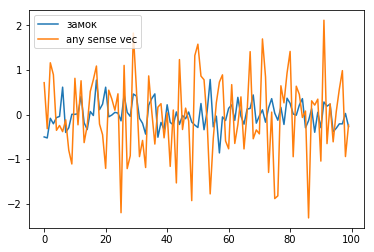

In [251]:
# plt.plot(wv['либуша'], label = 'либуша')
plt.plot(wv['замок'], label = 'замок')
# plt.plot(net.words_comps[0].data.numpy()[0]/np.sqrt(np.sum(net.words_comps[0].data.numpy()[0]**2)), label = 'any sense vec')
plt.plot(net.words_comps[0].data.numpy()[0], label = 'any sense vec')
plt.legend()

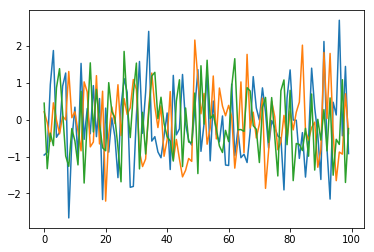

In [264]:
plt.plot(net.words_comps[0].data.numpy()[0])
plt.plot(net.words_comps[0].data.numpy()[1])
plt.plot(net.words_comps[0].data.numpy()[2])
# plt.semilogy()

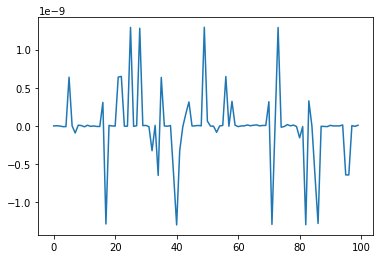

In [297]:
plt.plot(net.words_comps.grad[0][0].data.numpy())

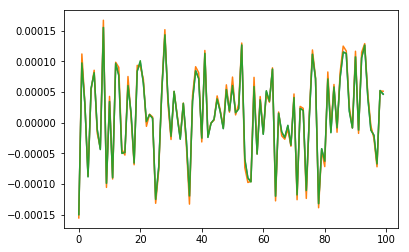

In [349]:
plt.plot(net.words_comps.grad[0].data.numpy().T)

# Triplet

Creates a criterion that measures the triplet loss given an input tensors x1, x2, x3
and a margin with a value greater than 0.


This is used for measuring a relative similarity between samples. A triplet is composed by
`a`, `p` and `n`: anchor, positive examples and negative example respectively.
The shape of all input variables should be :math:`(N, D)`.


The distance swap is described in detail in the paper
`Learning shallow convolutional feature descriptors with triplet losses`_ by V. Balntas, E. Riba et al.

 
$$L(a, p, n) = \frac{1}{N} \left( \sum_{i=1}^N \max \{d(a_i, p_i) - d(a_i, n_i) + {\rm margin}, 0\} \right)$$

where 
    
$$d(x_i, y_i) = \| {\bf x}_i - {\bf y}_i \|_2^2$$

    Args:
        * anchor: anchor input tensor
        * positive: positive input tensor
        * negative: negative input tensor
        p: the norm degree. Default: 2

Shape:
- Input: `(N, D)` where `D = vector dimension`
- Output:`(N, 1)`



    >>> triplet_loss = nn.TripletMarginLoss(margin=1.0, p=2)
    >>> input1 = autograd.Variable(torch.randn(100, 128))
    >>> input2 = autograd.Variable(torch.randn(100, 128))
    >>> input3 = autograd.Variable(torch.randn(100, 128))
    >>> output = triplet_loss(input1, input2, input3)
    >>> output.backward()

    .. _Learning shallow convolutional feature descriptors with triplet losses:
        http://www.iis.ee.ic.ac.uk/%7Evbalnt/shallow_descr/TFeat_paper.pdf

In [324]:
grads = {}
def save_grad(name):
    def hook(grad):
        grads[name] = grad
    return hook

In [325]:
# Multi-Component word embeddings

class MultiComp_triplet(nn.Module):
    def __init__(self, word_embeddings_to_comp, n_comp=3, margin = 0.1):
        """
        word_embeddings_to_comp: word embeddings of the target word;
                                 shape = (n_words,100);
        
        """
        super(MultiComp_triplet, self).__init__()
        self.n_comp = n_comp
        
        n_words, embedding_size = word_embeddings_to_comp.shape
        # expand to duplicate embeddings n_comp times
#         expanded_word_embeddings = np.expand_dims(word_embeddings_to_comp, 1)
#         comp_embeddings = np.tile(expanded_word_embeddings, [1, n_comp, 1])
        
#         # add some noise to components (1/3 of its standard deviations)
#         stds = word_embeddings_to_comp.std(axis=1, keepdims=True).reshape([n_words, 1, 1])
#         comp_embeddings += np.random.randn(n_words, n_comp, embedding_size)#  * stds  / 10
        comp_embeddings = np.random.randn(n_words, n_comp, embedding_size)#  * stds  / 10
        comp_embeddings = comp_embeddings.astype(np.float32)
        
#         self.n_centroids = np.random.randn(n_words, n_comp, embedding_size)#  * stds  / 10
#         self.n_centroids = self.n_centroids.astype(np.float32)
#         self.n_centroids = nn.Parameter(torch.from_numpy(self.n_centroids))
        
        # create variable to use autograd
        self.words_comps = nn.Parameter(torch.from_numpy(comp_embeddings))
        self.triplet_loss = nn.TripletMarginLoss(margin=margin, p=2)
                
    def forward(self, context_embeddings, negative_embeddings, word_n):
        """
        context_embeddings: shape = (n_context_words, 100);
        word_n: number of main_word for what the forward is running;
        
        """
        assert context_embeddings.shape[0] == negative_embeddings.shape[0]
        
        cont_sum = torch.mean(context_embeddings, dim=0)
#         scores = torch.matmul(self.n_centroids[word_n], cont_sum)
        self.scores = torch.matmul(self.words_comps[word_n], cont_sum)\
    /(torch.norm(self.words_comps[word_n])*torch.norm(cont_sum))
    
        self.scores = fn.softmax(self.scores, 0)
#         values, indices = scores.max(0)

        self.word_curr = torch.matmul(self.scores, self.words_comps[word_n])
        self.word_curr /= torch.norm(self.word_curr, p=2)
        
        self.context_embeddings = context_embeddings
        self.context_embeddings /= torch.norm(self.context_embeddings, p=2, dim=0)
        
        num_word_contxt = self.context_embeddings.shape[0]
        self.word_curr = self.word_curr.unsqueeze(0)
        self.word_curr_repeated = self.word_curr * Variable(torch.ones(num_word_contxt, 1))
#         word_curr_repeated = word_curr.repeat(num_word_contxt,1)
#         dot_prod = torch.matmul(word_curr, cont_sum.squeeze())/(torch.norm(word_curr, p=1) * torch.norm(cont_sum, p=1))
#         dot_prod -= torch.norm(cont_sum,p=2)
        loss = self.triplet_loss(self.word_curr_repeated, self.context_embeddings, negative_embeddings)\
    +torch.norm(self.word_curr)**2
    
        self.word_curr_repeated.register_hook(save_grad('word_curr_repeated'))
        self.word_curr.register_hook(save_grad('word_curr'))
        self.scores.register_hook(save_grad('scores'))
        
        return loss, self.scores

In [338]:
senses = Variable(torch.randn(3, 10), requires_grad=True)
pos = Variable(torch.randn(3, 10), requires_grad=True)
neg = Variable(torch.randn(3, 10), requires_grad=True)

loss_fn = nn.TripletMarginLoss(margin=0.001, p=2)
loss = loss_fn(senses, pos, neg)


In [339]:
loss.backward()

In [341]:
pos.grad

Variable containing:
-0.0197 -0.0508  0.0676 -0.0209 -0.1148 -0.2296 -0.0831 -0.1505 -0.0782 -0.0395
-0.0210  0.1347  0.0321 -0.1726  0.0625  0.2016 -0.0325  0.0946  0.0447  0.0718
 0.1047 -0.0837  0.0217  0.1315  0.0300 -0.1361 -0.0215  0.0978 -0.1678 -0.1334
[torch.FloatTensor of size 3x10]

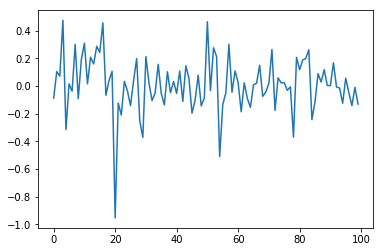

In [346]:
plt.plot(grads['word_curr'].data.numpy().T)

In [317]:
grads.keys()

dict_keys(['word_curr_repeated', 'word_curr', 'scores'])

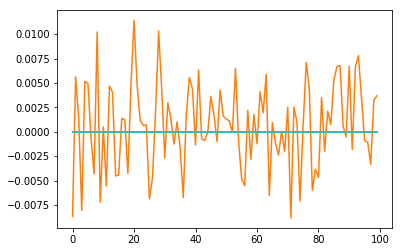

In [345]:
plt.plot(grads['word_curr_repeated'].data.numpy().T)

In [311]:
net.word_curr_repeated.grad

In [312]:
net.word_curr_repeated.requires_grad

True

In [313]:
net.word_curr_repeated

Variable containing:
 0.1764 -0.1513  0.1749  ...   0.0136 -0.0906  0.1293
 0.1764 -0.1513  0.1749  ...   0.0136 -0.0906  0.1293
 0.1764 -0.1513  0.1749  ...   0.0136 -0.0906  0.1293
          ...             ⋱             ...          
 0.1764 -0.1513  0.1749  ...   0.0136 -0.0906  0.1293
 0.1764 -0.1513  0.1749  ...   0.0136 -0.0906  0.1293
 0.1764 -0.1513  0.1749  ...   0.0136 -0.0906  0.1293
[torch.FloatTensor of size 20x100]

# Simple Test2

In [352]:
w_emb = np.random.randn(3, 100)
net = MultiComp_triplet(w_emb, margin=0.001)
opt = torch.optim.Adam(net.parameters(), lr=1e-1)


n_samples = 10000
n_context = 20 # number of words in the context
emb_dim = 100
pbar = tqdm_notebook(np.random.randn(n_samples, 2, n_context, emb_dim))

for n, (sample_p, sample_n) in enumerate(pbar):
    # Prepare sample with Variable wrap
    sample_p = Variable(torch.from_numpy(sample_p.astype(np.float32)))
    sample_n = Variable(torch.from_numpy(sample_n.astype(np.float32)))
    
    net.zero_grad()
    dot_prod, att = net.forward(sample_p, sample_n, 0)
    loss = dot_prod
    loss.backward()
    opt.step()
    if n % 100 == 99:
        pbar.set_description("loss {:.3f}".format(float(loss.data.numpy())))
#     print(loss)
#     print("attn: ", att)

HBox(children=(IntProgress(value=0, max=10000), HTML(value='')))

# Train

In [8]:
def generate_triplet_batch(lines, context_max_len):

    voc_size = len(wv.vocab)
    for line in lines:
        line = line.split()
        embedd_p = []
        context = np.random.choice(line, context_max_len)
        for i, w in enumerate(context):
            try:
                embedd_p.append(wv[w])
            except KeyError:
                continue
        embedd_n = [wv[wv.index2word[i]] for i in np.random.random_integers(0, voc_size-1, len(embedd_p))]
        yield np.array(embedd_p), np.array(embedd_n)

In [354]:
w_emb = wv['замок'].reshape((1,100))
net = MultiComp_triplet(w_emb, 3, margin=0.000001)
opt = torch.optim.Adam(net.parameters(), lr=1e2)


n_samples = len(lines)
n_context = 20 # number of words in the context
emb_dim = 100
atts = list()
epoch_num = 5
losses = []
for epoch in range(epoch_num):
    batch_gen = generate_triplet_batch(lines, context_max_len=n_context)
    pbar = tqdm_notebook(batch_gen, total = n_samples)
    print("epoch_num: ", epoch)
    for n, (sample_p, sample_n) in enumerate(pbar):
        if len(sample_p)==0:
            continue
        # Prepare sample with Variable wrap
        sample_p = Variable(torch.from_numpy(sample_p.astype(np.float32)))
        sample_n = Variable(torch.from_numpy(sample_n.astype(np.float32)))
        
        net.zero_grad()
        loss, att = net.forward(sample_p, sample_n, 0)
        atts.append(att.data.numpy())
        loss.backward()
        opt.step()
        losses.append(loss.data.numpy())
        if n % 100 == 99:
            pbar.set_description("loss {:.3f}".format(float(np.mean(losses[-10:]))))

HBox(children=(IntProgress(value=0, max=111462), HTML(value='')))

epoch_num:  0


/home/fogside/virtualenvs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: This function is deprecated. Please call randint(0, 202435 + 1) instead
  del sys.path[0]


Exception in thread Thread-30:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/fogside/virtualenvs/py3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/fogside/virtualenvs/py3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



KeyboardInterrupt: 

In [272]:
wv.similar_by_vector(net.words_comps[0].data.numpy()[2], 30)

[('раздумывать', 0.5402257442474365),
 ('корсить', 0.5333212614059448),
 ('подуматься', 0.5312578082084656),
 ('просто', 0.5312464833259583),
 ('сталкиваться', 0.5309513807296753),
 ('подходить', 0.5256808996200562),
 ('меряться', 0.5221322774887085),
 ('то', 0.5182496309280396),
 ('но', 0.5181222558021545),
 ('не', 0.5180255770683289),
 ('подумать', 0.5178244113922119),
 ('веренный', 0.517769455909729),
 ('он', 0.5171695947647095),
 ('девать', 0.5149160623550415),
 ('поверяться', 0.5119913220405579),
 ('тесноватый', 0.5107848644256592),
 ('подевать', 0.5102100968360901),
 ('задеваться', 0.509039580821991),
 ('подталкивать', 0.5082801580429077),
 ('удивляться', 0.5078020691871643),
 ('ненно', 0.5068950653076172),
 ('коно', 0.5062024593353271),
 ('решаться', 0.5059964656829834),
 ('майка', 0.5054994225502014),
 ('удивлять', 0.5053404569625854),
 ('замечать', 0.5052223801612854),
 ('пока', 0.5047560334205627),
 ('подбирать', 0.5044084191322327),
 ('уверенно', 0.5040613412857056),
 ('прис

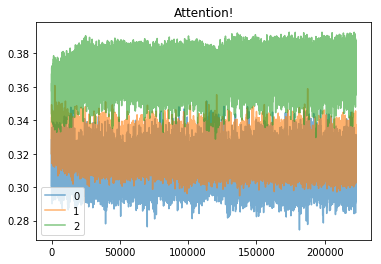

In [271]:
atts = np.array(atts)
for i in range(3):
    plt.plot(atts[:,i], label = i, alpha=0.6)
plt.legend()
plt.title("Attention!")
plt.show()

# TF

In [18]:
import tensorflow as tf
import numpy as np

class MultiComp:
    def __init__(self, emb_size, n_comp, margin):
        self.pos = tf.placeholder(dtype=tf.float32, shape=[None, emb_size], name='pos_ph')
        self.neg = tf.placeholder(dtype=tf.float32, shape=[None, emb_size], name='neg_ph')
        self.lr = tf.placeholder(dtype=tf.float32, shape=[], name='learning_rate_ph')
#         self.ref = tf.placeholder(dtype=float32, [None, emb_size], name='ref_ph')

        comp_init = np.random.randn(n_comp, emb_size) / np.sqrt(emb_size * n_comp)
        self.sense_comps = tf.Variable(comp_init, dtype=tf.float32, name='senses')
        
        # Attention
        mean_cont = tf.reduce_mean(self.pos, axis=0, keep_dims=True)
        mean_cont = tf.nn.l2_normalize(mean_cont, 1)  # 1 x 100
        
        norm_sens = tf.nn.l2_normalize(self.sense_comps, 1) # n_comp x 100
        
        att = tf.reduce_sum(mean_cont * norm_sens, axis=1, keep_dims=True)
        self.att = tf.nn.softmax(att, dim=0)
        word_emb = tf.reduce_sum(self.sense_comps * self.att, axis=0, keep_dims=True)
        
        
        # Cosine loss
        norm_pos = tf.nn.l2_normalize(self.pos, 1)
        norm_neg = tf.nn.l2_normalize(self.neg, 1)
        norm_word_emb = tf.nn.l2_normalize(word_emb, 1)
        
        pos_loss = tf.reduce_mean(tf.reduce_sum(norm_pos * norm_word_emb, axis=1))
        neg_loss = tf.reduce_mean(tf.reduce_sum(norm_neg * norm_word_emb, axis=1))
        
        self.loss = -pos_loss + neg_loss
        opt = tf.train.AdamOptimizer(self.lr)
        self.train_op = opt.minimize(self.loss)
        
        self.sess = tf.Session()
        self.sess.run(tf.global_variables_initializer())
        
    def train_on_sample(self, pos_samp, neg_samp, learning_rate):
        feed_dict = {self.pos: pos_samp, self.neg: neg_samp, self.lr: learning_rate}
        loss, att, _ = self.sess.run([self.loss, self.att, self.train_op], feed_dict)
        return loss, att
            
        
        
        
#     def train(self, 
net = MultiComp(100, 3, 0.1)

pos = np.random.randn(10, 100)
neg = np.random.randn(10, 100)

net.train_on_sample(pos, neg, 1e-3)

(-0.018445704, array([[0.34381938],
        [0.31128237],
        [0.34489822]], dtype=float32))

In [42]:
w_emb = wv['замок'].reshape((1,100))
net = MultiComp(100, 3, 0.1)
lr = 1e-0


n_samples = len(lines)
n_context = 20 # number of words in the context
emb_dim = 100
atts = list()
epoch_num = 5
losses = []
for epoch in range(epoch_num):
    batch_gen = generate_triplet_batch(lines, context_max_len=n_context)
    pbar = tqdm_notebook(batch_gen, total = n_samples)
    print("epoch_num: ", epoch)
    for n, (sample_p, sample_n) in enumerate(pbar):
        if len(sample_p)==0:
            continue
        
        loss, att = net.train_on_sample(sample_p, sample_n, lr)
        atts.append(att)
        losses.append(loss)
        
        if n % 100 == 99:
            pbar.set_description("loss {:.3f}".format(float(np.mean(losses))))

HBox(children=(IntProgress(value=0, max=111462), HTML(value='')))

epoch_num:  0


/home/fogside/virtualenvs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: This function is deprecated. Please call randint(0, 202435 + 1) instead
  del sys.path[0]


HBox(children=(IntProgress(value=0, max=111462), HTML(value='')))

epoch_num:  1


KeyboardInterrupt: 

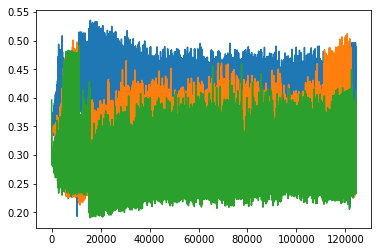

In [43]:
plt.plot(np.array(atts).squeeze())

In [12]:
from tqdm import tqdm_notebook

In [48]:
vecs = net.sess.run(net.sense_comps)

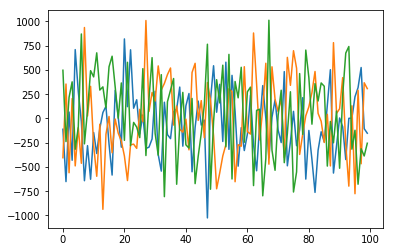

In [46]:
plt.plot(net.sess.run(net.sense_comps).T)

In [50]:
wv.similar_by_vector(vecs[0], 100)

[('сердиться', 0.6758785843849182),
 ('ты', 0.6620959639549255),
 ('хотеть', 0.6607041358947754),
 ('виноватый', 0.6584303975105286),
 ('обижать', 0.6551534533500671),
 ('винить', 0.6551117300987244),
 ('вы', 0.6514453291893005),
 ('поверять', 0.6483024954795837),
 ('обижаться', 0.646203339099884),
 ('уверять', 0.6380212903022766),
 ('признаваться', 0.6363065838813782),
 ('честно', 0.6357573866844177),
 ('наговаривать', 0.6352356672286987),
 ('я', 0.635108470916748),
 ('прощать', 0.6333035230636597),
 ('пожалеть', 0.6332321166992188),
 ('рассердиться', 0.6332260370254517),
 ('сказать', 0.6304179430007935),
 ('стыдно', 0.6301324367523193),
 ('сознаваться', 0.6300578117370605),
 ('послушать', 0.6280498504638672),
 ('извинять', 0.6279995441436768),
 ('укорять', 0.6266547441482544),
 ('разубеждать', 0.6259697079658508),
 ('рад', 0.62589430809021),
 ('жаль', 0.6251907348632812),
 ('доверяться', 0.624801754951477),
 ('говорить', 0.6239533424377441),
 ('сердить', 0.6238747835159302),
 ('прого

In [51]:
wv.similar_by_vector(vecs[1], 30)

[('number', 0.6564533710479736),
 ('</s>', 0.6273416876792908),
 ('xxi', 0.6091017127037048),
 ('европейский', 0.5965313911437988),
 ('вовторых', 0.588162362575531),
 ('период', 0.579221785068512),
 ('политикоэкономический', 0.5771236419677734),
 ('северорусский', 0.5755876302719116),
 ('xv', 0.5731698870658875),
 ('российский', 0.572288990020752),
 ('англорусский', 0.5709666013717651),
 ('основывать', 0.5706570148468018),
 ('вопервых', 0.5695275068283081),
 ('xix', 0.5657012462615967),
 ('сформирование', 0.5644468069076538),
 ('центральноевропейский', 0.5635027289390564),
 ('xviii', 0.5626835227012634),
 ('фактический', 0.5613923668861389),
 ('втретьих', 0.5594233870506287),
 ('значительный', 0.5592941045761108),
 ('североевропейский', 0.5592177510261536),
 ('xii', 0.5592120289802551),
 ('сюникский', 0.5589029788970947),
 ('xi', 0.5578298568725586),
 ('этнополитический', 0.5570239424705505),
 ('англоамериканский', 0.5565569400787354),
 ('общеевропейский', 0.5565346479415894),
 ('общес

In [52]:
wv.similar_by_vector(vecs[2], 30)

[('решетчатый', 0.5929557681083679),
 ('висячий', 0.5427316427230835),
 ('двухстворчатый', 0.5397512316703796),
 ('арчатый', 0.5387513041496277),
 ('оконце', 0.5373989343643188),
 ('бойница', 0.537075936794281),
 ('зубчатый', 0.5318499803543091),
 ('проем', 0.5303755402565002),
 ('башенка', 0.5294720530509949),
 ('створчатый', 0.5281323790550232),
 ('полукруглый', 0.5264857411384583),
 ('виднеться', 0.5261988043785095),
 ('полуобвалиться', 0.5221297144889832),
 ('балкончик', 0.5219922661781311),
 ('створка', 0.5218627452850342),
 ('вделывать', 0.5197611451148987),
 ('рифленый', 0.519519567489624),
 ('незастекленный', 0.5192326307296753),
 ('ребристый', 0.5174426436424255),
 ('ставня', 0.517245888710022),
 ('воротца', 0.5165739059448242),
 ('перильце', 0.5158848762512207),
 ('проржавелый', 0.51492840051651),
 ('щелистый', 0.5144843459129333),
 ('карниз', 0.511212944984436),
 ('задвижной', 0.5095570683479309),
 ('куполок', 0.5068346261978149),
 ('бревенчатый', 0.5060204863548279),
 ('ста

In [24]:
from matplotlib import pyplot as plt
%matplotlib inline